In [1]:
import numpy as np
import sys
import matplotlib
from scipy.optimize import curve_fit
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline,interp1d

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('../qslam')
sys.path.append('../paperdata/')

from visualiserisk import *
from qslamdesignparams import GRIDDICT

PATHDICT['pdir'] = '../paperdata/data_v3/'

# Define Error Analysis Regime

Pick loss metric type as (SSIM or RMS) to numerically extract low-loss lambda values:

In [2]:
metrictype_ = 3 # SSIM
metrictypename = 'SSIM'
# metrictype_ = 2 # RMS
# metrictypename = 'RMS'

Pick fixed lambda (False) regime:

In [3]:
OPT_LAMBDA=True
fix_lambda_at_iteration = [4, 3, 4] #
fix_lambda_at_iteration_max = [8, 8, 8]
# START_OPT = 2 # don;t chnage this
# excludes large error scores (few msmts) from the fit 
# to emphasize accuracy for middle and low error scores

Pick fitting method (a) least squares exponential fit ('expfit') or univariate interpolation ('linfit', 'rbffit')

In [4]:
FIT_TYPE='linfit'

# Define Experiment Parameter Regimes

The set of parameters are given in the dictionary format, LOOPS_DICT, and used for analysis via ParamUpdater. They are fixed for the type of simulations investigated. 

In [5]:
# Choose defaults to match floor case (heights didn't work)
TRUTHKWARGS = {}

BARRIER_FLOOR = 0.25*np.pi
BARRIER_HEIGHT = 0.75*np.pi
FLOOR_RATIO = 0.4 # matches floor case

TRUTHKWARGS["OneStepdheight"] = {"low": BARRIER_FLOOR, 
                                 "high": BARRIER_HEIGHT} 
TRUTHKWARGS["OneStepdfloorarea"] = FLOOR_RATIO 

prefix_list = ['2019_Jun_1D', '2019_Jun_2D', '2019_Jun_2D_Gssn'] 

# ------------------------------------------------------------------------------
# TURN OFF PARAMETER SCANS
# ------------------------------------------------------------------------------

idx_prevar = 0 
# Fix truth configurations
meta_truth_floor_scan = [FLOOR_RATIO] # [0.2, 0.4, 0.6, 0.8, 1.0]
lowscan = [BARRIER_FLOOR] # np.asarray([0.2]*5)*np.pi
highscan = [BARRIER_HEIGHT] # np.asarray([0.2, 0.4, 0.6, 0.8, 1.0])*np.pi
truth_step_scan = zip(lowscan, highscan)


idx_noise_var = 0 
# Fix to noiseless case
noiseclasses = ['noiseless'] 
noisestrengths = [0.0]
meta_noisevar_scan = zip(noiseclasses, noisestrengths)


# Fix msmt scan - and turn it off!
msmt_per_qubit_scan = [1] # [1, 2, 4, 5, 6, 8, 10, 15, 20, 25, 50]

# ------------------------------------------------------------------------------

In [6]:
# ------------------------------------------------------------------------------
# NEW PARAMETER SCANS
# ------------------------------------------------------------------------------

meta_max_iter_scan = [ 5, 10, 15, 20, 25, 50, 75, 100, 125, 250]

lambda_databse = np.load('../paperdata/lambda_pairs_2.npz')
lambda1 = list(lambda_databse['lambda_1']) # [0.99, 0.956, 0.922, 0.888, 0.854, 0.820, 0.786, 0.752, 0.718, 0.684, 0.65]
lambda2 = list(lambda_databse['lambda_2']) # [0.977, 0.9752, 0.9734, 0.9716, 0.9698, 0.968, 0.9662, 0.9644, 0.9626, 0.9608, 0.959]
lambda_scan = zip(lambda1, lambda2)

LOOPS_DICT = {"meta_truth_floor_scan": meta_truth_floor_scan,
              "meta_max_iter_scan":meta_max_iter_scan, 
              "meta_noisevar_scan": meta_noisevar_scan,
              "truth_step_scan": truth_step_scan,
              "lambda_scan":lambda_scan,
              "msmt_per_qubit_scan": msmt_per_qubit_scan}

ParamUpdater = DataCube(LOOPS_DICT)


# Get Data Filenames

In [7]:
weightratioslist = []
msmtperqubitlist = []

for prefix in prefix_list:
    
    # simplify loops
    idx_noise_var =0
    idx_var_dict =0

    regime_ID = prefix + '_n_' + str(idx_noise_var) +'_vset_' + str(idx_var_dict)
    datafile = '../paperdata/data_v3/'+'RISK_' + regime_ID +'.npz'

    if idx_var_dict == 0:
        weightratioslist.append(datafile) 
    elif idx_var_dict ==1 :
        msmtperqubitlist.append(datafile)

# Data variables
max_msmtvar = len(ParamUpdater.meta_max_iter_scan)
max_var = max(len(ParamUpdater.lambda_scan), len(ParamUpdater.msmt_per_qubit_scan))


print("Number of values of max-iterations in T tested:", max_msmtvar)
if idx_var_dict == 0:
    print("Number of lambda-values tested:", max_var)
    print("weightratioslist represents data files for analysis where lambda values are tested for each T")
if idx_var_dict == 1:
    print("Number of variations for which msmts per qubit per iteration is varied:", max_var)
    print("msmtperqubitlist represents data files for analysis where lambda values are tested for each T")

('Number of values of max-iterations in T tested:', 10)
('Number of lambda-values tested:', 250)
weightratioslist represents data files for analysis where lambda values are tested for each T


# Extract Optimal Lambda 

In [8]:
max_lambda_var_ = max_var
max_cases = len(weightratioslist)
max_msmt_var = len(ParamUpdater.meta_max_iter_scan)
max_var = len(ParamUpdater.lambda_scan)
idx_prevar=0


def get_loss_data(filename, idx_prevar, idx_msmt_var, max_lambda_var=250, metrictype=3):
    ''' Return qslam loss values, naive data loss values, and list of index for lambda values from low to highest loss.
    Type of loss value (SSIM, RMS) is determined by metrictype.
    
    Returns:
    --------
    
            qslamdata (`float` | array):
                Expected loss values for qslam algorithm according risk metrictype 
            
            index_array (`int` | int):
                List of int denoting index of lambda values sorted from lowest to highest loss
            
            naivedata (`float` | array):
                Expected loss values for naive algorithm according risk metrictype 
    
            metrictype: Index of loss metric used in Risk_Matrix_Generator
                `2` : Root mean square metric
                `3` : Expected SSIM metric
    '''
    
    full_data_matrix = np.load(filename)["full_data_matrix"]    
    qslamdata = full_data_matrix[idx_prevar, idx_msmt_var, : max_lambda_var, 0, metrictype]
    #qslam is the first index
    naivedata = full_data_matrix[idx_prevar, idx_msmt_var, : max_lambda_var, 1, metrictype]
    index_array = np.argsort(qslamdata)
    
    return qslamdata, index_array, naivedata


def extract_optimal_cases(weightratioslist, max_cases, max_msmt_var, max_lambda_var=250, metrictype=3):
    '''
    Return optimal lambda and loss informatio for a set of chosen experiments.
    This function draws the following parameters from the global namespace: weightratioslist
        
    '''
    
    optimal_matrix = np.zeros((max_cases, max_msmt_var, 3))
    naive_matrix = np.zeros((max_cases, max_msmt_var, 2))
    optimal_cases = np.zeros((max_cases, max_msmt_var, max_lambda_var))
    
    for idx_msmt_var in range(max_msmt_var):
        
        for idx_truth in range(max_cases):
            
            filename = weightratioslist[idx_truth]
            a, index_array, naive = get_loss_data(filename, idx_prevar, idx_msmt_var, 
                                                  max_lambda_var=max_lambda_var,
                                                  metrictype=metrictype)


            optimal_matrix[idx_truth, idx_msmt_var, 0] = a[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 1] = lambda1[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 2] = lambda2[index_array[0]]

            naive_matrix[idx_truth, idx_msmt_var, 0] = np.mean(naive)
            naive_matrix[idx_truth, idx_msmt_var, 1] = np.std(naive)
            
            truncate = len(index_array)           
            optimal_cases[idx_truth, idx_msmt_var, :truncate] = index_array
    
    return optimal_matrix, naive_matrix, optimal_cases


def norm_rmse_error_propagation(residualsdata):

    # independent error anlaysis across trials
    MSE = np.mean(residualsdata**2, axis=0)
    STD = np.std(residualsdata**2, axis=0)
    rel_error_MSE = MSE / STD
    RMSE = np.sqrt(MSE) 
    RSTD = RMSE * 0.5 * rel_error_MSE # error propagation from  X to Y when Y = X^n
    
    return RMSE, RSTD

# Analyze Lambda Values from Datasets

In [9]:
optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(weightratioslist, max_cases, max_msmt_var, 
                                                                    max_lambda_var=max_lambda_var_,
                                                                    metrictype=metrictype_)

print('Type of loss metric (name, flag):', metrictypename, metrictype_)
# Replace optimal case for SSIM index with second best case for Gaussian field
if metrictype_ == 3 or metrictype_ ==2:
    optimal_cases[2, [4, 5, 9], 0] = optimal_cases[2, [4, 5, 9], 1]
    print("Second best case for m=4, 5, 9 in Gaussian 2D field", optimal_cases[2, [4, 5,9], 0])

print "Optimal lambda values for each truth and max T"
print optimal_cases[:, :, 0]

# Pick fixed-choice lambda regimes
pick_lambda_idx = [int(optimal_cases[0, fix_lambda_at_iteration[0], 0])]
pick_lambda_idx+= [int(optimal_cases[1, fix_lambda_at_iteration[1], 0])]
pick_lambda_idx+= [int(optimal_cases[2, fix_lambda_at_iteration[2], 0])]

# Pick high T regime fixed lambda for Supplements Fig. 1 (fix_lambda_at_iteration_max)
pick_lambda_idx_max = [int(optimal_cases[0, fix_lambda_at_iteration_max[0], 0])]
pick_lambda_idx_max+= [int(optimal_cases[1, fix_lambda_at_iteration_max[1], 0])]
pick_lambda_idx_max+= [int(optimal_cases[2, fix_lambda_at_iteration_max[2], 0])] 

print "Fixed lambda values for each truth (fixed-lamda choice regime)"
print pick_lambda_idx

print "Fixed lambda values for each truth (Fig 1, column 2 of Supplementary Materials)"
print pick_lambda_idx_max

('Type of loss metric (name, flag):', 'SSIM', 3)
('Second best case for m=4, 5, 9 in Gaussian 2D field', array([ 85., 157., 225.]))
Optimal lambda values for each truth and max T
[[ 63. 140. 124. 107. 140.  83.  12. 132.  12. 124.]
 [125. 130. 107. 130.  29. 230.  12. 208. 216. 124.]
 [186. 211.  12. 173.  85. 157. 100. 157. 141. 225.]]
Fixed lambda values for each truth (fixed-lamda choice regime)
[140, 130, 85]
Fixed lambda values for each truth (Fig 1, column 2 of Supplementary Materials)
[12, 216, 141]


#  Error Analysis

### Load Specific-Lambda Experiments for Error Analysis

msmts = ParamUpdater.meta_max_iter_scan[:]
print "Exclude from fit Avg. Loss scores for msmts less than:", msmts[START_OPT]

def fit_expn(t, a, b):
    '''Exponential fitting function'''
    return a * np.exp(t*b) + msmts[START_OPT] # excludes large error scores (few msmts) from the fit

def fit_plaw(t, a, b):
    '''Power-law fitting function'''
    return a / (t**b)

In [10]:
nmqa_dobjs = []
naive_dobjs = []

for idx_case in range(max_cases): # loop over true physical experiments 
    
    for idx_msmt_var in range(max_msmt_var): # loop over max iterations for each experiment

        # select lambda values for a fixed max iteration budget
        if OPT_LAMBDA:
            idx_optimal_lambda_var = int(optimal_cases[idx_case, idx_msmt_var, 0])
        
        if not OPT_LAMBDA:
            idx_optimal_lambda_var = pick_lambda_idx[idx_case]

        # compile data filename for specific lambda values
        regime_ID =  prefix_list[idx_case] + '_n_' + str(idx_noise_var) +'_vset_' + str(idx_var_dict)
        testcase_ID = regime_ID + '_t_' + str(idx_prevar) + '_m_' + str(idx_msmt_var)
        unique_ID =  testcase_ID + '_v_' + str(idx_optimal_lambda_var)

        PATHDICT["fle"] = unique_ID
        
        # load data for specific lambda values
        try:
            qslamdata = np.load(path_to_file(PATHDICT, flag='q'))
            nmqa_dobjs.append(qslamdata)
            naivedata = np.load(path_to_file(PATHDICT, flag='n'))
            naive_dobjs.append(naivedata)
            print("Loaded", unique_ID)
            
        except:
            print("ERROR. Unique ID:", unique_ID)
            continue

('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_0_v_63')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_1_v_140')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_2_v_124')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_3_v_107')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_4_v_140')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_5_v_83')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_6_v_12')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_7_v_132')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_8_v_12')
('Loaded', '2019_Jun_1D_n_0_vset_0_t_0_m_9_v_124')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_0_v_125')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_1_v_130')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_2_v_107')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_3_v_130')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_4_v_29')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_5_v_230')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_6_v_12')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_7_v_208')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_0_m_8_v_216')
('Loaded', '2019_Jun_2D_n_0_vset_0_t_

### Compute loss metrics and reshape data

In [11]:
trials=50
msmts = ParamUpdater.meta_max_iter_scan[:]

if len(nmqa_dobjs) == len(naive_dobjs):
    
    qslam_rms, naive_rms, qslam_ssim, naive_ssim = [], [], [], []
    
    for idx in range(len(nmqa_dobjs)):
        
        qslamdata, naivedata = nmqa_dobjs[idx], naive_dobjs[idx]
    
        perqubit_qslamdata = np.sqrt(np.mean(qslamdata['macro_residuals'][0]**2, axis= 1)) / np.pi
        qslam_rms.append(perqubit_qslamdata)

        perqubit_naivedata = np.sqrt(np.mean(naivedata['macro_residuals'][0]**2, axis= 1)) / np.pi
        naive_rms.append(perqubit_naivedata)

        qslam_ssim.append(Metric.ssim(qslamdata, Cone=0.001, Ctwo=0.001)[1])
        naive_ssim.append(Metric.ssim(naivedata, Cone=0.001, Ctwo=0.001)[1])
    
    
for dataset in ['qslam_rms', 'naive_rms', 'qslam_ssim', 'naive_ssim']:
    vars()[dataset] = np.asarray(vars()[dataset]).reshape(max_cases, max_msmt_var, trials)

### Compute expected loss and standard deviations of datasets

In [12]:
for dataset in ['qslam_rms', 'naive_rms', 'qslam_ssim', 'naive_ssim']:
    
    vars()[dataset+'_exp_loss'] = np.mean(vars()[dataset], axis=2)
    vars()[dataset+'_std_loss'] = np.std(vars()[dataset], axis=2)
    vars()[dataset+'_errbar_upp'] = vars()[dataset+'_exp_loss'] + vars()[dataset+'_std_loss']
    vars()[dataset+'_errbar_low'] = vars()[dataset+'_exp_loss'] - vars()[dataset+'_std_loss']


### Optimise fit to expected loss, upper and lower bounds of dataset

In [13]:
if FIT_TYPE != 'mixfit':
    x_space = np.linspace(0.0, 1.0, 601)  
if FIT_TYPE == 'mixfit':
    x_space = np.linspace(0.0, 0.5, 601)
    
labels = ['mean', 'upper bound', 'lower bound']
data_labels = ['qslam_rms', 'naive_rms', 'qslam_ssim', 'naive_ssim']

### Least Squares Fit

In [14]:
def fit_expn(t, a, b, c):
    '''Exponential fitting function'''
    return a * np.exp(t*b) + c  # c excludes large error scores (few msmts) from the fit

def fit_sqrt(t, a, b, c):
    '''Assume fintie variance and uncorrelated random variables,  variance of average of t random variables
    is sigma ^2 / t. So expect reduction in variance proportional to 1 / sqrt(t).
    
    '''
    
    return (a /np.sqrt(t*b)) + c  # b excludes large error scores (few msmts) from the fit
    

In [15]:
if FIT_TYPE == 'mixfit':
    
    START_OPT_LIST =[2, 0, 2, 0]
    
    curve_fit_data = np.empty((max_cases, 4, 3, 3))
    
    for idx_case in range(max_cases):

        print(prefix_list[idx_case])

        for idx_dataset in range(4):

            dataset = data_labels[idx_dataset]

            fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))

            # Plot expected loss, upper and lower bounds for each case:

            ax.errorbar(msmts, vars()[dataset+'_exp_loss'][idx_case], 
                        yerr= vars()[dataset+'_std_loss'][idx_case], 
                        c='gray')
            ax.plot(msmts,  vars()[dataset+'_errbar_upp'][idx_case], 
                    msmts,  vars()[dataset+'_errbar_low'][idx_case], 
                    c='darkred', ls='--', alpha=0.2)
            ax.set(title='Avg '+ dataset +' vs. T', xlabel='Max iterations (T) ', ylabel='Avg. loss')


            # Plot loss data and optimise fit

            axes = [ax2, ax3, ax4]
            xvals = [vars()[dataset+'_exp_loss'][idx_case], vars()[dataset+'_errbar_upp'][idx_case], vars()[dataset+'_errbar_low'][idx_case]]
            y_vals = msmts
            
            if idx_dataset == 1 or idx_dataset == 3:

                fit_func = fit_sqrt
                INIT = [1.0, 1., 1.]
                BNDS=((-np.inf,  -np.inf, -np.inf), (np.inf,  np.inf, np.inf))
                INIT_L = INIT
                BNDS_L = BNDS
                
            if idx_dataset == 0 or idx_dataset == 2:              
                
                fit_func = fit_expn
                INIT = [100.0, -10.0, 15.0]
                BNDS=((0, -np.inf, 15.0), (np.inf, 0, np.inf))
                INIT_L = [100.0, -10.0, 1.]
                BNDS_L=((0, -np.inf, 0.5), (np.inf, 0, 5))

            for idx_plot in range(3):
                
                START_OPT = START_OPT_LIST[idx_dataset]
                END_OPT=14
                if idx_plot == 2:
                    START_OPT=2
                    END_OPT = 12

                x_vals = xvals[idx_plot][0:max_msmt_var]
                
                if idx_plot != 2:

                    aopt, bopt, copt = curve_fit(fit_func,
                                                 x_vals[START_OPT:END_OPT], 
                                                 y_vals[START_OPT:END_OPT], 
                                                 p0=INIT, bounds=BNDS)[0]

                if idx_plot == 2:
                    aopt, bopt, copt = curve_fit(fit_func,  
                                                 x_vals[START_OPT:END_OPT], 
                                                 y_vals[START_OPT:END_OPT], 
                                                 p0=INIT_L, bounds=BNDS_L)[0]

                    
                axes[idx_plot].set_title(labels[idx_plot]+'\n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt),
                                                                                        bopt,
                                                                                         np.round(copt)))


                curve_fit_data[idx_case, idx_dataset, idx_plot, : ] = [aopt, bopt, copt]

                axes[idx_plot].plot(x_vals, y_vals, 'x')
                axes[idx_plot].plot(x_space, fit_func(x_space, aopt, bopt, copt))
                axes[idx_plot].set(ylabel='Max iterations (T) ', xlabel='Avg. loss')
                axes[idx_plot].set_xscale('log')
                axes[idx_plot].set_yscale('log')
            plt.show()


In [16]:
if FIT_TYPE == 'expfit':
    
    fit_func = fit_expn
        
    INIT = [100.0, -10.0, 15.0]
    BNDS=((0, -np.inf, 15.0), (np.inf, 0, np.inf))

    INIT_L = [100.0, -10.0, 1.]
    BNDS_L=((0, -np.inf, 0.5), (np.inf, 0, 5))

    START_OPT_LIST =[2]*4
    curve_fit_data = np.empty((max_cases, 4, 3, 3))
    
    for idx_case in range(max_cases):

        print(prefix_list[idx_case])

        for idx_dataset in range(4):

            dataset = data_labels[idx_dataset]

            fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))

            # Plot expected loss, upper and lower bounds for each case:

            ax.errorbar(msmts, vars()[dataset+'_exp_loss'][idx_case], 
                        yerr= vars()[dataset+'_std_loss'][idx_case], 
                        c='gray')
            ax.plot(msmts,  vars()[dataset+'_errbar_upp'][idx_case], 
                    msmts,  vars()[dataset+'_errbar_low'][idx_case], 
                    c='darkred', ls='--', alpha=0.2)
            ax.set(title='Avg '+ dataset +' vs. T', xlabel='Max iterations (T) ', ylabel='Avg. loss')


            # Plot loss data and optimise power law fit

            axes = [ax2, ax3, ax4]
            xvals = [vars()[dataset+'_exp_loss'][idx_case], vars()[dataset+'_errbar_upp'][idx_case], vars()[dataset+'_errbar_low'][idx_case]]
            y_vals = msmts

            START_OPT = START_OPT_LIST[idx_dataset]

            END_OPT = 12

            for idx_plot in range(3):
                print(START_OPT)

                x_vals = xvals[idx_plot][0:max_msmt_var]

                if not OPT_LAMBDA and idx_plot != 2:
                    aopt, bopt, copt = curve_fit(fit_func,  x_vals[START_OPT:],  y_vals[START_OPT:], 
                                                 p0=INIT, bounds=BNDS)[0]

                    axes[idx_plot].set_title(labels[idx_plot]+'\n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt), np.round(bopt), np.round(copt)))


                if OPT_LAMBDA and idx_plot != 2:

                    aopt, bopt, copt = curve_fit(fit_func,  x_vals[START_OPT:] ,  y_vals[START_OPT:], 
                                                 p0=INIT,  bounds=BNDS)[0]

                    axes[idx_plot].set_title(labels[idx_plot]+'\n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt), np.round(bopt), np.round(copt)))

                if idx_plot == 2:

                    aopt, bopt, copt = curve_fit(fit_func,  x_vals[: END_OPT] ,  y_vals[:END_OPT], 
                                                 p0=INIT_L,  bounds=BNDS_L)[0]

                    axes[idx_plot].set_title(labels[idx_plot]+' BL \n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt), np.round(bopt), np.round(copt)))

                curve_fit_data[idx_case, idx_dataset, idx_plot, : ] = [aopt, bopt, copt]

                axes[idx_plot].plot(x_vals, y_vals, 'x')
                axes[idx_plot].plot(x_space, fit_func(x_space, aopt, bopt, copt))
                axes[idx_plot].set(ylabel='Max iterations (T) ', xlabel='Avg. loss')
                # axes[idx_plot].set_title(labels[idx_plot]+'\n $a=$%s, $b=$%s, $c=$%s ' %(np.round(aopt), np.round(bopt), np.round(copt)))
                axes[idx_plot].set_xscale('log')
                axes[idx_plot].set_yscale('log')
            plt.show()


### Univariate smoothing and interpolation fits

In [17]:
LINFIT ={}

for idx_case in range(max_cases):
    LINFIT[str(idx_case)] = {}
    for idx_dataset in range(4):
        LINFIT[str(idx_case)][data_labels[idx_dataset]] = {}
        for idx_plot in range(len(labels)):
            LINFIT[str(idx_case)][data_labels[idx_dataset]] = {"str": 0.01, "end":0.6}
            
LINFIT[str(0)][data_labels[0]]["str"] = 0.0
LINFIT[str(0)][data_labels[0]]["end"] = 0.35
LINFIT[str(0)][data_labels[1]] = LINFIT[str(0)][data_labels[0]]

LINFIT[str(1)][data_labels[0]]["str"] = 0.0
LINFIT[str(1)][data_labels[0]]["end"] = 0.35
LINFIT[str(1)][data_labels[1]] = LINFIT[str(1)][data_labels[0]]

LINFIT[str(2)][data_labels[0]]["str"] = 0.0
LINFIT[str(2)][data_labels[0]]["end"] = 0.35
LINFIT[str(2)][data_labels[1]] = LINFIT[str(2)][data_labels[0]]

for idx_case in range(max_cases):

    LINFIT[str(idx_case)][data_labels[2]]["str"] = 0.05
    LINFIT[str(idx_case)][data_labels[2]]["end"] = 0.6
    LINFIT[str(idx_case)][data_labels[3]] = LINFIT[str(idx_case)][data_labels[2]]

2019_Jun_1D


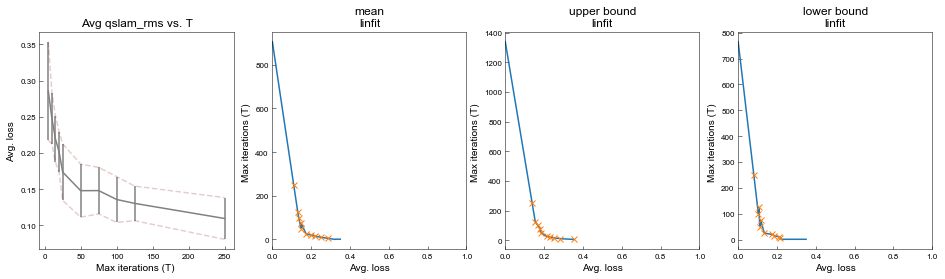

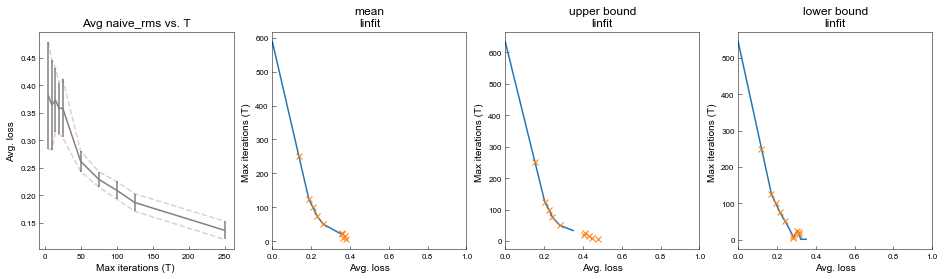

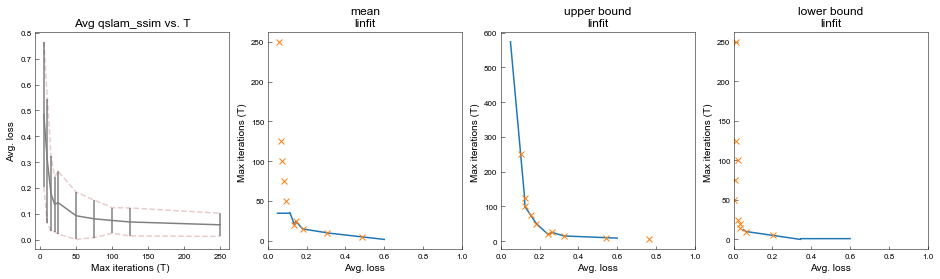

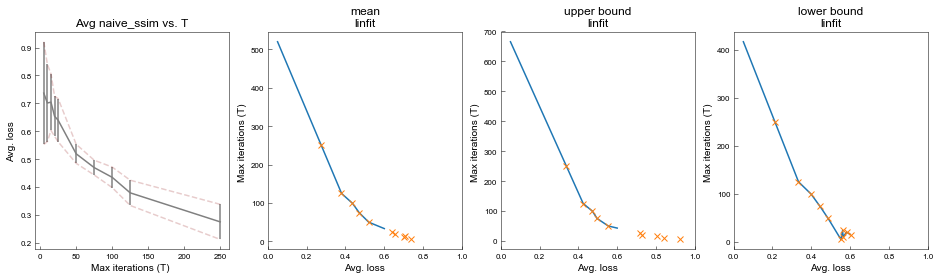

2019_Jun_2D


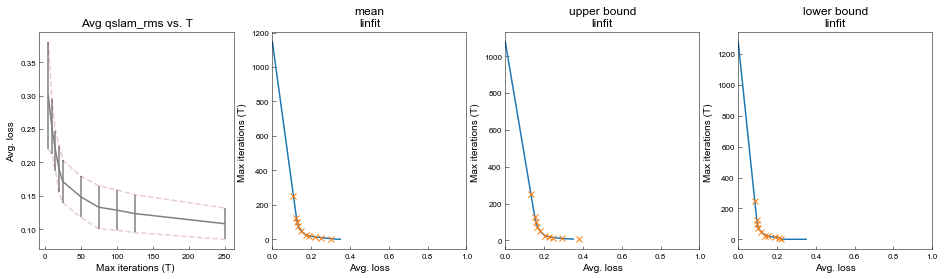

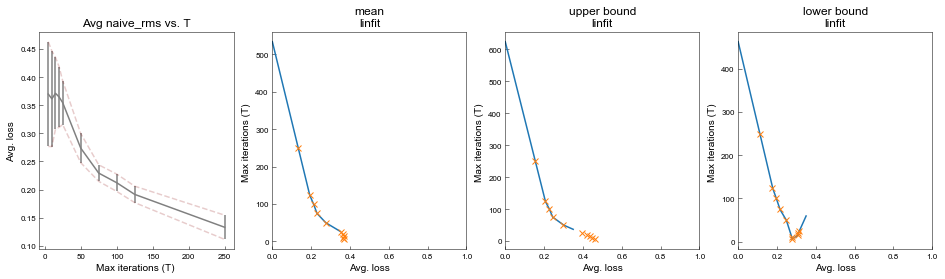

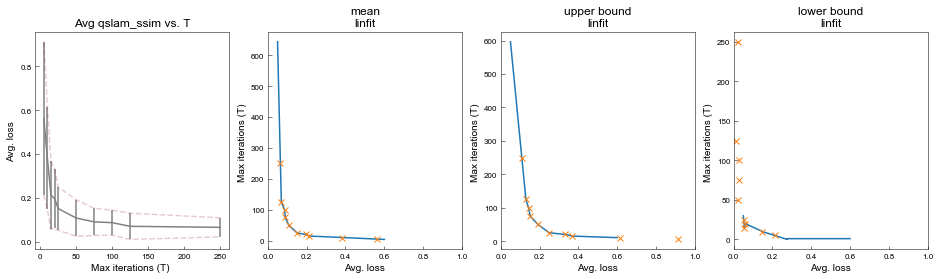

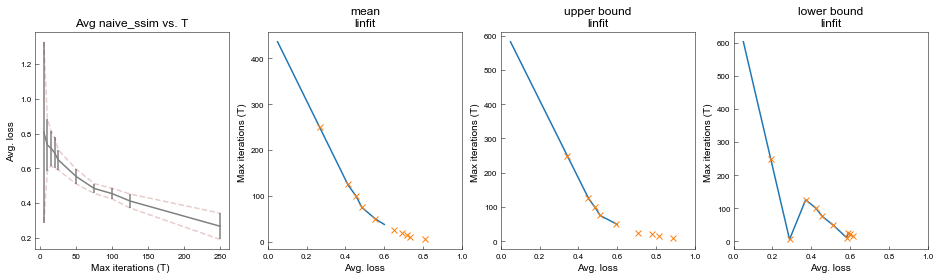

2019_Jun_2D_Gssn


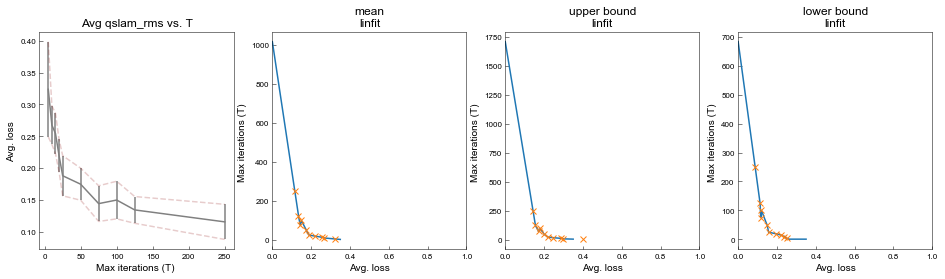

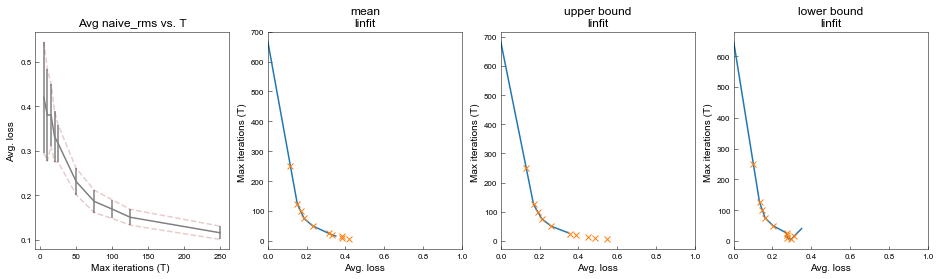

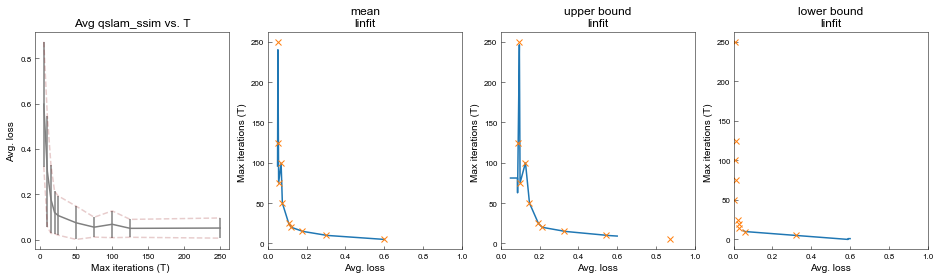

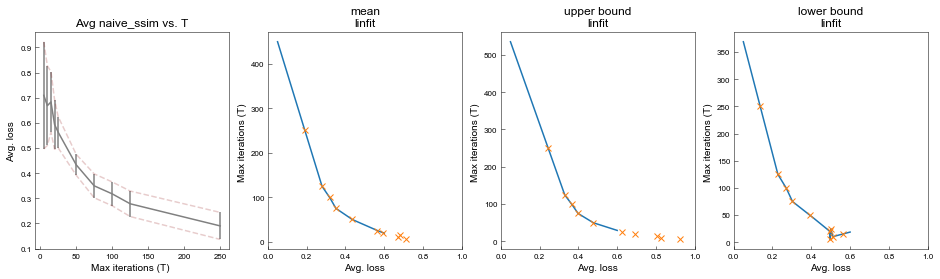

In [18]:
if FIT_TYPE == 'rbffit' or FIT_TYPE == 'linfit' or  FIT_TYPE == 'unifit':  
    
    curve_fit_data = np.empty((max_cases, 4, 3, len(x_space)))
    
    for idx_case in range(max_cases):

        print(prefix_list[idx_case])

        for idx_dataset in range(4):

            dataset = data_labels[idx_dataset]

            fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,4))

            # Plot expected loss, upper and lower bounds for each case:

            ax.errorbar(msmts, vars()[dataset+'_exp_loss'][idx_case], 
                        yerr= vars()[dataset+'_std_loss'][idx_case], 
                        c='gray')
            ax.plot(msmts,  vars()[dataset+'_errbar_upp'][idx_case], 
                    msmts,  vars()[dataset+'_errbar_low'][idx_case], 
                    c='darkred', ls='--', alpha=0.2)
            
            ax.set(title='Avg '+ dataset +' vs. T', xlabel='Max iterations (T) ', ylabel='Avg. loss')


            # Plot loss data and optimise power law fit

            axes = [ax2, ax3, ax4]
            xvals = [vars()[dataset+'_exp_loss'][idx_case], vars()[dataset+'_errbar_upp'][idx_case], vars()[dataset+'_errbar_low'][idx_case]]
            y_vals = msmts
            
            START = LINFIT[str(idx_case)][data_labels[idx_dataset]]["str"]
            END = LINFIT[str(idx_case)][data_labels[idx_dataset]]["end"]
            
            x_space = np.linspace(START, END, 601)
            
            for idx_plot in range(3):

                x_vals = xvals[idx_plot][0:max_msmt_var]
                
                if FIT_TYPE == 'rbffit':
                    interpolate_func = Rbf(x_vals, y_vals)
                
                if FIT_TYPE == 'linfit':
                    interpolate_func = interp1d(x_vals, y_vals, assume_sorted=False,fill_value='extrapolate')
                
                if FIT_TYPE == 'unifit':
                    interpolate_func = InterpolatedUnivariateSpline(x_vals, y_vals)

                interpolated_values = interpolate_func(x_space)
                
                if idx_plot == 0 and idx_case == 0 and idx_dataset == 2:
                    interpolated_values[0:70] = [interpolated_values[71]]*70
                if idx_plot == 1 and idx_case == 2 and idx_dataset == 2:
                    interpolated_values[0:40] = [interpolated_values[41]]*40
                
                interpolated_values[interpolated_values<0] = 1.
                
                curve_fit_data[idx_case, idx_dataset, idx_plot, : ] = interpolated_values
                
                axes[idx_plot].set_title(labels[idx_plot]+'\n' + FIT_TYPE)
                axes[idx_plot].plot(x_space, interpolated_values)             
                axes[idx_plot].plot(x_vals, y_vals, 'x')              
                axes[idx_plot].set(ylabel='Max iterations (T) ', xlabel='Avg. loss')
                axes[idx_plot].set_xlim([0,1])
#                 axes[idx_plot].set_xscale('log')
#                 axes[idx_plot].set_yscale('log')
                
            plt.show()


# Save error analysis curve fitting data

In [19]:
figdatafile = './FIGURES/' + metrictypename+'_'+ str(metrictype_)+'_'+'_opt_'+ str(OPT_LAMBDA)
figdatafile += '_' + FIT_TYPE
print(figdatafile)
np.savez(figdatafile, curve_fit_data=curve_fit_data, opt_lambda=OPT_LAMBDA, loss_metric=metrictypename)

./FIGURES/SSIM_3__opt_True_linfit


# Compute ratio and plot final data figure

### Take the ratio of expected naive / nmqa expected loss and computed expected supremum and infimum bounds for the ratio



RMS/$\pi$: 1D array
('Ratio drops below unity for score:', 0.08983333333333332)
('Max ratio', 1624.8750124331784, 'for score ', 0.32316666666666666)
('Ratio at Avg. SSIM = 0.3: ', 12.460234245371982)


RMS/$\pi$: 2D square field
('Ratio drops below unity for score:', 0.09974999999999999)
('Max ratio', 4353.383788502263, 'for score ', 0.3470833333333333)
('Ratio at Avg. SSIM = 0.3: ', 8.41064499632102)


RMS/$\pi$: 2D Gaussian field
('Ratio drops below unity for score:', 0.11433333333333331)
('Max ratio', 6.059873545294442, 'for score ', 0.35)
('Ratio at Avg. SSIM = 0.3: ', 4.19190965542071)


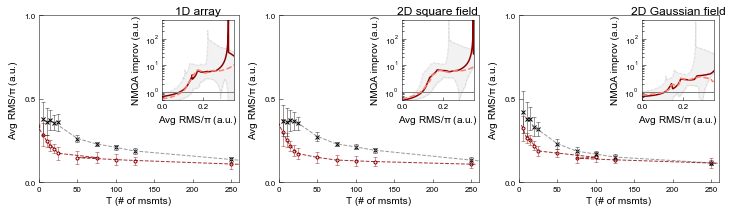



SSIM: 1D array
('Ratio drops below unity for score:', 0.23241666666666666)
('Max ratio', 24.325037124553496, 'for score ', 0.17924999999999996)
('Ratio at Avg. SSIM = 0.1: ', 13.240734443060433)


SSIM: 2D square field
('Ratio drops below unity for score:', 0.05733333333333333)
('Max ratio', 19.816635379031307, 'for score ', 0.21133333333333332)
('Ratio at Avg. SSIM = 0.1: ', 6.579602447128299)


SSIM: 2D Gaussian field
('Ratio drops below unity for score:', 0.23241666666666666)
('Max ratio', 17.815921828972243, 'for score ', 0.17741666666666667)
('Ratio at Avg. SSIM = 0.1: ', 12.618473859802515)


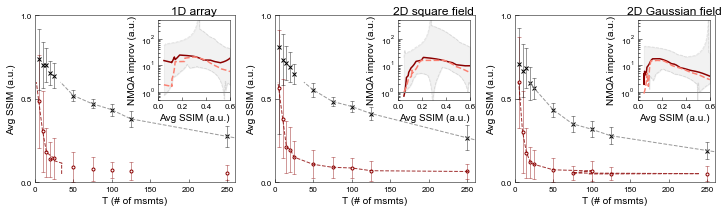

In [40]:
loss_label = ['RMS/$\pi$', 'SSIM']
case_titles = ['1D array', '2D square field', '2D Gaussian field']
XLIMMAX = 260

if FIT_TYPE == 'linfit':

    for plot_metric in [0, 1]: # 0 RMS, 1# SSIM

        fig, axes_ = plt.subplots(1, 3, figsize=(cm2inch(30.95), cm2inch(7.8)))
        axes = np.empty_like(axes_)
        axes = np.vstack([axes, axes])


        for idx_case in range(3):
            
            idx_dataset_nmqa = plot_metric*2
            idx_dataset_naive = plot_metric*2 + 1
            
            START = LINFIT[str(idx_case)][data_labels[idx_dataset_nmqa]]["str"]
            END = LINFIT[str(idx_case)][data_labels[idx_dataset_nmqa]]["end"] # doesn't matter if naive or nmqa
            x_space = np.linspace(START, END, 601)

            axes[0, idx_case] = axes_[idx_case]
            axes[1, idx_case] = inset_axes(axes[0, idx_case], width=1, height=1.1)#, loc=4)


            naive_vals, nmqa_vals = [], []
            for idx_label in range(3):

                naive_vals.append(curve_fit_data[idx_case, idx_dataset_naive, idx_label, : ]) 
                nmqa_vals.append(curve_fit_data[idx_case, idx_dataset_nmqa, idx_label, : ] )

            naive_vals = np.asarray(naive_vals)
            nmqa_vals = np.asarray(nmqa_vals)
            naive_mask = naive_vals<=XLIMMAX
            nmqa_mask = nmqa_vals<=XLIMMAX


            # compute ratio
            mean = naive_vals[0] / nmqa_vals[0]
            high = naive_vals[1] / nmqa_vals[2]
            low  = naive_vals[2] / nmqa_vals[1]

            print 
            print
            print(loss_label[plot_metric] + ': ' +case_titles[idx_case])
            below_unity_arg = len(mean[0:200][mean[0:200]<1.0]) - 1
            print("Ratio drops below unity for score:", x_space[0:200][below_unity_arg])
            print("Max ratio", np.max(mean), "for score ", x_space[np.argmax(mean)])
            
            if plot_metric ==0:
                condition_match = np.argwhere(np.round(x_space, 3)==0.3)
                at_point_1 = int(condition_match[-1])
                print("Ratio at Avg. SSIM = 0.3: ", mean[at_point_1] )
                
            if plot_metric ==1:
                condition_match = np.argwhere(np.round(x_space, 3)==0.10)
                at_point_1 = int(condition_match[-1])
                print("Ratio at Avg. SSIM = 0.1: ", mean[at_point_1] )


            axes[1, idx_case].set_title(case_titles[idx_case])

            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                                   'o', ms=3, markerfacecolor='white', markeredgecolor='darkred', label='NMQA')
            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                                   'x', ms=3.5, c='k', label='Naive')

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_nmqa] +'_std_loss'][idx_case],
                         alpha=0.5 , color='darkred', ls='none',capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_naive] +'_std_loss'][idx_case], 
                         alpha=0.5, color='k', ls='none', capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].plot(naive_vals[0][naive_mask[0]], x_space[naive_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='gray', label='Naive Fit')
            axes[0, idx_case].plot(nmqa_vals[0][nmqa_mask[0]], x_space[nmqa_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='darkred', label='NMQA Fit')

            axes[0, idx_case].yaxis.set_ticks(np.arange(0., 1.1, 0.5))
            axes[0, idx_case].set_ylim([0., 1.])
            axes[0, idx_case].set_xlim([0, 260])
#             axes[0, idx_case].set_yscale('log')
#             axes[0, idx_case].set_xscale('log')

#             axes[0, idx_case].set_ylim([10**-3, 2* 10**0])        
#             axes[0, idx_case].set_xlim([4*10**0, 3*10**2])        

            MAINCOLOR='darkred'
            MAINLABEL='Numerically Tuned'
            if not OPT_LAMBDA:
                MAINCOLOR='salmon'
                MAINLABEL='Fixed Choice'
            axes[1, idx_case].plot(x_space, mean, '-', c=MAINCOLOR, lw=1.5,
                                  label=r'$\lambda_{1,2}$ ' + MAINLABEL)
            axes[1, idx_case].plot(x_space, high, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].plot(x_space, low, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].fill_between(x_space, y1=high, y2=low, color='gray', alpha=0.1, label='Est. Uncert.')
            axes[1, idx_case].axhline(y=1.0, lw=1.0, c='gray', ls='-')
            axes[1, idx_case].set_yscale('log') 
            
            axes[1, idx_case].set_ylim([5*10**-1, 5 * 10.**2])
#             if plot_metric == 1:
#                 axes[1, idx_case].set_ylim([0.5 * 10**-1, 5 * 10.**5])
 
            if FIT_TYPE == 'linfit':
            
                axes[1, idx_case].set_xlim([0., END])        
        

            axes[0, idx_case].set_xlabel('T (# of msmts)')
            axes[1, idx_case].set_xlabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[0, idx_case].set_ylabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[1, idx_case].set_ylabel('NMQA improv (a.u.)')


        if OPT_LAMBDA:

            fixed_curve_fit_data = np.load('./FIGURES/SSIM_3__opt_False_'+FIT_TYPE+'.npz')['curve_fit_data']

            for idx_case in range(3):

                fnaive_vals = fixed_curve_fit_data[idx_case, idx_dataset_naive, 0, : ] 
                fnmqa_vals = fixed_curve_fit_data[idx_case, idx_dataset_nmqa, 0, : ] 

                fixed_mean = np.asarray(fnaive_vals) / np.asarray(fnmqa_vals)

                axes[1, idx_case].plot(x_space, fixed_mean, '--', c='salmon', lw=1.5,
                                       label=r'$\lambda_{1,2}$ Fixed Choice')
    #     axes[0, 0].legend()
    #     axes[1, 0].legend(loc=3)

        figdatafile =  metrictypename+'_'+ str(metrictype_)+'_opt_'+ str(OPT_LAMBDA)+'_'+str(plot_metric)
        figdatafile += '_' + FIT_TYPE
        plt.savefig('./FIGURES/' +figdatafile+'.svg', format='svg', dpi=900)
        plt.show()

In [21]:
loss_label = ['RMS/$\pi$', 'SSIM']
case_titles = ['1D array', '2D square field', '2D Gaussian field']
XLIMMAX = 260

if FIT_TYPE == 'expfit' or FIT_TYPE == 'mixfit':

    for plot_metric in [0, 1]: # 0 RMS, 1# SSIM

        fig, axes_ = plt.subplots(1, 3, figsize=(cm2inch(30.95), cm2inch(7.8)))
        axes = np.empty_like(axes_)
        axes = np.vstack([axes, axes])


        for idx_case in range(3):

            idx_dataset_nmqa = plot_metric*2
            idx_dataset_naive = plot_metric*2 + 1

            axes[1, idx_case] = axes_[idx_case]

            if plot_metric == 0:
                axes[0, idx_case] = inset_axes(axes[1, idx_case], width=2, height=0.8)#, loc=4)
            if plot_metric == 1:
                axes[0, idx_case] = inset_axes(axes[1, idx_case], width=2, height=0.8)

            naive_vals, nmqa_vals = [], []
            for idx_label in range(3):

                opt_naive = curve_fit_data[idx_case, idx_dataset_naive, idx_label, : ] 
                opt_nmqa = curve_fit_data[idx_case, idx_dataset_nmqa, idx_label, : ] 

                # extract fitting function
                if FIT_TYPE == 'expfit':
                    naive_vals.append(fit_expn(x_space, opt_naive[0], opt_naive[1],  opt_naive[2]))
                
                if FIT_TYPE == 'mixfit':
                    naive_vals.append(fit_sqrt(x_space, opt_naive[0], opt_naive[1],  opt_naive[2]))
                nmqa_vals.append(fit_expn(x_space, opt_nmqa[0], opt_nmqa[1],  opt_nmqa[2]))

            naive_vals = np.asarray(naive_vals)
            nmqa_vals = np.asarray(nmqa_vals)
            naive_mask = naive_vals<=XLIMMAX
            nmqa_mask = nmqa_vals<=XLIMMAX


            # compute ratio
            mean = naive_vals[0] / nmqa_vals[0]
            high = naive_vals[1] / nmqa_vals[2]
            low  = naive_vals[2] / nmqa_vals[1]

            print 
            print
            print(loss_label[plot_metric] + ': ' +case_titles[idx_case])
            below_unity_arg = len(mean[0:100][mean[0:100]<1.0]) - 1
            print("Ratio drops below unity for score:", x_space[0:100][below_unity_arg])
            print("Max ratio", np.max(mean), "for score ", x_space[np.argmax(mean)])

            at_point_1 = int(np.argwhere(x_space==0.1))
            print("Ratio at Avg. SSIM = 0.1: ", mean[at_point_1] )


            axes[1, idx_case].set_title(case_titles[idx_case])

            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                                   'o', ms=3, markerfacecolor='white', markeredgecolor='darkred', label='NMQA')
            axes[0, idx_case].plot( msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                                   'x', ms=3.5, c='k', label='Naive')

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_nmqa] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_nmqa] +'_std_loss'][idx_case],
                         alpha=0.5 , color='darkred', ls='none',capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].errorbar(msmts, vars()[data_labels[idx_dataset_naive] +'_exp_loss'][idx_case],
                         yerr=vars()[data_labels[idx_dataset_naive] +'_std_loss'][idx_case], 
                         alpha=0.5, color='k', ls='none', capsize=2, elinewidth=0.8, markeredgewidth=0.8)

            axes[0, idx_case].plot(naive_vals[0][naive_mask[0]], x_space[naive_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='gray', label='Naive Fit')
            axes[0, idx_case].plot(nmqa_vals[0][nmqa_mask[0]], x_space[nmqa_mask[0]], '--', lw=1.0,
                                   alpha=0.8, c='darkred', label='NMQA Fit')

            axes[0, idx_case].yaxis.set_ticks(np.arange(0., 1.1, 0.5))
    #         axes[0, idx_case].set_ylim([0., 1.])
    #         axes[0, idx_case].set_xlim([0, 260])
            axes[0, idx_case].set_yscale('log')
            axes[0, idx_case].set_xscale('log')

            axes[0, idx_case].set_ylim([10**-3, 2* 10**0])        
            axes[0, idx_case].set_xlim([4*10**0, 3*10**2])        

            MAINCOLOR='darkred'
            MAINLABEL='Numerically Tuned'
            if not OPT_LAMBDA:
                MAINCOLOR='salmon'
                MAINLABEL='Fixed Choice'
            axes[1, idx_case].plot(x_space, mean, '-', c=MAINCOLOR, lw=1.5,
                                  label=r'$\lambda_{1,2}$ ' + MAINLABEL)
            axes[1, idx_case].plot(x_space, high, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].plot(x_space, low, '--', c='gray', lw=0.8, alpha=0.2)
            axes[1, idx_case].fill_between(x_space, y1=high, y2=low, color='gray', alpha=0.1, label='Est. Uncert.')
            axes[1, idx_case].axhline(y=1.0, lw=1.0, c='gray', ls='-')
            axes[1, idx_case].set_yscale('log') 
            axes[1, idx_case].set_ylim([10**-2, 5 * 10.**5])
            if plot_metric == 1:
                axes[1, idx_case].set_ylim([0.5 * 10**-1, 5 * 10.**5])

            if FIT_TYPE != 'mixfit':
                axes[1, idx_case].set_xlim([0., 1.])  
            if FIT_TYPE == 'mixfit':
                axes[1, idx_case].set_xlim([0., 0.5])        
        

            axes[0, idx_case].set_xlabel('T (# of msmts)')
            axes[1, idx_case].set_xlabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[0, idx_case].set_ylabel(r'Avg '+loss_label[plot_metric]+' (a.u.)')
            axes[1, idx_case].set_ylabel('NMQA improvement (multiples)')


        if OPT_LAMBDA:

            fixed_curve_fit_data = np.load('./FIGURES/SSIM_3__opt_False_'+FIT_TYPE+'.npz')['curve_fit_data']

            for idx_case in range(3):

                fixed_naive = fixed_curve_fit_data[idx_case, idx_dataset_naive, 0, : ] 
                fixed_nmqa = fixed_curve_fit_data[idx_case, idx_dataset_nmqa, 0, : ] 

                # extract fitting function
                if FIT_TYPE == 'expfit':
                    fnaive_vals = fit_expn(x_space, fixed_naive[0], fixed_naive[1],  fixed_naive[2])
                
                if FIT_TYPE == 'mixfit':
                    fnaive_vals = fit_sqrt(x_space, fixed_naive[0], fixed_naive[1],  fixed_naive[2])

                fnmqa_vals = fit_expn(x_space, fixed_nmqa[0], fixed_nmqa[1],  fixed_nmqa[2])

                fixed_mean = np.asarray(fnaive_vals) / np.asarray(fnmqa_vals)

                axes[1, idx_case].plot(x_space, fixed_mean, '--', c='salmon', lw=1.5,
                                       label=r'$\lambda_{1,2}$ Fixed Choice')
    #     axes[0, 0].legend()
    #     axes[1, 0].legend(loc=3)

        figdatafile =  metrictypename+'_'+ str(metrictype_)+'_opt_'+ str(OPT_LAMBDA)+'_'+str(plot_metric)
        figdatafile += '_' + FIT_TYPE
        plt.savefig('./FIGURES/' +figdatafile+'.svg', format='svg', dpi=900)
        plt.show()

# Optimal Lambda  - a graphical depiction

regimes chosen: [4, 8]
('truth:', 0, 'idx_opt', 0)
(0.8020446691287545, 0.9634308352251595)
('truth:', 0, 'idx_opt', 1)
(0.928048883679283, 0.6800648439146815)
regimes chosen: [3, 8]
('truth:', 1, 'idx_opt', 0)
(0.8879998072544012, 0.9688521082118846)
('truth:', 1, 'idx_opt', 1)
(0.8439217498106487, 0.9639036594593563)
regimes chosen: [4, 8]
('truth:', 2, 'idx_opt', 0)
(0.8285960961737775, 0.5496634544865366)
('truth:', 2, 'idx_opt', 1)
(0.7694625442180772, 0.9716358529648438)


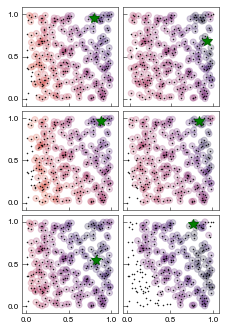

In [22]:
THRESHOLD = 0.05 # effects graphical shading of optimal lambda results

# Choose colormap
cmap = plt.cm.inferno
# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))
# Set alpha
my_cmap[:,-1] = np.ones(cmap.N)*0.2
# Create new colormap
my_cmap = ListedColormap(my_cmap)

gslayout = gs(3, 2 , top = 0.95, bottom =0.05, left = 0.1, right = 0.9, wspace = 0.05, hspace = 0.05)


fig = plt.figure(figsize=(cm2inch(8.7), cm2inch(12)))

for truth in range(len(weightratioslist)):
    
    pick_msmt_regimes = [fix_lambda_at_iteration[truth], fix_lambda_at_iteration_max[truth]]
    print "regimes chosen:", pick_msmt_regimes
       
    for idx_opt in range(len(pick_msmt_regimes)):
    
        filename = weightratioslist[truth]
        idx_msmt_var= pick_msmt_regimes[idx_opt]
        
        a, index_array, naive = get_loss_data(filename, idx_prevar, idx_msmt_var,
                                              max_lambda_var=max_lambda_var_, metrictype=metrictype_)
        
        
        ax = fig.add_subplot(gslayout[truth, idx_opt ])
        ax.plot(lambda1[0:max_lambda_var_], lambda2[0:max_lambda_var_], 'ko', ms=0.5, alpha=1)
        
        # Make the star green if it's the best option but worse than lambda1=lambda2=0
        optimal_color = 'green'
        diff = a[0] - a[index_array[0]]  
        if diff < 0 :
            optimal_color = 'red'
        elif diff >=0 :
            if diff < THRESHOLD: 
                optimal_color = 'red'
                
        
        better_than_control=[]
        for idx_l in index_array:
            diff = a[0] - a[idx_l] 
            
            # Do nothing if the candidate pair has score greater than lambda1=lambda2=0 
            if diff < 0 :
                break
            elif diff >=0 :
                if diff < THRESHOLD: 
                    break
            if idx_l == 0:
                break
            
            # Store candidate pair index if it has a score less than lambda1=lambda2=0 
            better_than_control.append(idx_l)
        
        # Take loss values at indicies for candidate pairs that are better than than lambda1=lambda2=0 

        red_values = np.take(a, better_than_control)
        im = ax.scatter(np.take(lambda1, better_than_control), 
                        np.take(lambda2, better_than_control),
                        c= red_values,
                        vmin=0.0, vmax=1.0, 
                        cmap=my_cmap)
        
        # Plot a crimson star at the optimal lambda value (best performing candidate pair)
        
#         ax.plot(lambda1[index_array[0]],lambda2[index_array[0]], '*', markeredgecolor='darkgreen',
#                 c=optimal_color, ms=10, alpha=1.)

        if idx_opt == 0:
            pick_lambda = pick_lambda_idx
        if idx_opt == 1:
            pick_lambda = pick_lambda_idx_max

        print("truth:", truth, "idx_opt", idx_opt)
        print(lambda1[pick_lambda[truth]], lambda2[pick_lambda[truth]])
        ax.plot(lambda1[pick_lambda[truth]],lambda2[pick_lambda[truth]], '*', 
                markeredgecolor='darkgreen',
                c=optimal_color, ms=10, alpha=1.) 

        if idx_opt >0:
            ax.get_yaxis().set_ticklabels([])
        if truth < 2:
            ax.get_xaxis().set_ticklabels([])
        
        # Want square graphs with same number of ticks
        # ax.set_aspect(1.)
        equaltics = plticker.MultipleLocator(base=0.5) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(equaltics)
        ax.yaxis.set_major_locator(equaltics)
        # ax.set(xlabel=r'$\lambda_i $', ylabel=r'$\lambda_j$')
        # ax.set_title(str(ParamUpdater.meta_max_iter_scan[pick_msmt_regimes[idx_opt]])+', '+str(np.round(a[index_array[0]] / a[0], 3)))
        
# plt.colorbar(im, ticks=[0.0, 1.0], format='%0.1f', orientation='horizontal')
figdatafile =  metrictypename+'_'+ str(metrictype_)+'_opt_'+ str(OPT_LAMBDA)+'_'
plt.savefig('./FIGURES/' + figdatafile+'optimisation.svg', format='svg', dpi=900)
plt.show()

In [23]:
optimal_cases[:, :, 0]

array([[ 63., 140., 124., 107., 140.,  83.,  12., 132.,  12., 124.],
       [125., 130., 107., 130.,  29., 230.,  12., 208., 216., 124.],
       [186., 211.,  12., 173.,  85., 157., 100., 157., 141., 225.]])

In [24]:
for idx_case in range(3):
    
    print("TRUTH: ", prefix_list[idx_case])
    for idx_msmt_regime in range(len(msmts)):
    
        print("Msmts", msmts[idx_msmt_regime])
        opt_lambda =  int(optimal_cases[idx_case, idx_msmt_regime, 0])
        print("Index for optimal lambda: ", opt_lambda)
        print("Optimal pair: ", lambda1[opt_lambda], lambda2[opt_lambda] )
        print
    print
    print

('TRUTH: ', '2019_Jun_1D')
('Msmts', 5)
('Index for optimal lambda: ', 63)
('Optimal pair: ', 0.32906477693954317, 0.9586025647787869)

('Msmts', 10)
('Index for optimal lambda: ', 140)
('Optimal pair: ', 0.8020446691287545, 0.9634308352251595)

('Msmts', 15)
('Index for optimal lambda: ', 124)
('Optimal pair: ', 0.8924845559974132, 0.9269768774689031)

('Msmts', 20)
('Index for optimal lambda: ', 107)
('Optimal pair: ', 0.971231028691702, 0.9445977633378564)

('Msmts', 25)
('Index for optimal lambda: ', 140)
('Optimal pair: ', 0.8020446691287545, 0.9634308352251595)

('Msmts', 50)
('Index for optimal lambda: ', 83)
('Optimal pair: ', 0.908800994856734, 0.7393367812824037)

('Msmts', 75)
('Index for optimal lambda: ', 12)
('Optimal pair: ', 0.928048883679283, 0.6800648439146815)

('Msmts', 100)
('Index for optimal lambda: ', 132)
('Optimal pair: ', 0.9512544265933524, 0.6921826265033336)

('Msmts', 125)
('Index for optimal lambda: ', 12)
('Optimal pair: ', 0.928048883679283, 0.68006484